In [1]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split\
    (boston.data, boston.target, random_state=0)

# 缩放数据
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [4]:
warnings.filterwarnings("default")

In [5]:
poly = PolynomialFeatures(degree=2).fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_poly.shape: {}".format(X_train_poly.shape))

X_train.shape: (379, 13)
X_train_poly.shape: (379, 105)


In [6]:
print("Polynomial feature names:\n{}".format(poly.get_feature_names_out()))

Polynomial feature names:
['1' 'x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x7' 'x8' 'x9' 'x10' 'x11' 'x12'
 'x0^2' 'x0 x1' 'x0 x2' 'x0 x3' 'x0 x4' 'x0 x5' 'x0 x6' 'x0 x7' 'x0 x8'
 'x0 x9' 'x0 x10' 'x0 x11' 'x0 x12' 'x1^2' 'x1 x2' 'x1 x3' 'x1 x4' 'x1 x5'
 'x1 x6' 'x1 x7' 'x1 x8' 'x1 x9' 'x1 x10' 'x1 x11' 'x1 x12' 'x2^2' 'x2 x3'
 'x2 x4' 'x2 x5' 'x2 x6' 'x2 x7' 'x2 x8' 'x2 x9' 'x2 x10' 'x2 x11'
 'x2 x12' 'x3^2' 'x3 x4' 'x3 x5' 'x3 x6' 'x3 x7' 'x3 x8' 'x3 x9' 'x3 x10'
 'x3 x11' 'x3 x12' 'x4^2' 'x4 x5' 'x4 x6' 'x4 x7' 'x4 x8' 'x4 x9' 'x4 x10'
 'x4 x11' 'x4 x12' 'x5^2' 'x5 x6' 'x5 x7' 'x5 x8' 'x5 x9' 'x5 x10'
 'x5 x11' 'x5 x12' 'x6^2' 'x6 x7' 'x6 x8' 'x6 x9' 'x6 x10' 'x6 x11'
 'x6 x12' 'x7^2' 'x7 x8' 'x7 x9' 'x7 x10' 'x7 x11' 'x7 x12' 'x8^2' 'x8 x9'
 'x8 x10' 'x8 x11' 'x8 x12' 'x9^2' 'x9 x10' 'x9 x11' 'x9 x12' 'x10^2'
 'x10 x11' 'x10 x12' 'x11^2' 'x11 x12' 'x12^2']


## 在使用 Ridge(L2正则) 时，交互特征和多项式特征对性能有很大的提升

In [7]:
from sklearn.linear_model import Ridge
ridge = Ridge().fit(X_train_scaled, y_train)
print("Score without interactions: {:.3f}".format(
    ridge.score(X_test_scaled, y_test)))
ridge = Ridge().fit(X_train_poly, y_train)
print("Score with interactions: {:.3f}".format(
    ridge.score(X_test_poly, y_test)))

Score without interactions: 0.577
Score with interactions: 0.741


In [8]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100).fit(X_train_scaled, y_train)
print("Score without interactions: {:.3f}".format(
    rf.score(X_test_scaled, y_test)))
rf = RandomForestRegressor(n_estimators=100).fit(X_train_poly, y_train)
print("Score with interactions: {:.3f}".format(rf.score(X_test_poly, y_test)))

Score without interactions: 0.771
Score with interactions: 0.755


想要在 scikit-learn 中使用单变量特征选择，你需要选择一项测试——对分类问题通常是 f_classif （默认值），对回归问题通常是 f_regression ——然后基于测试中确定的 p 值来选择一种舍弃特征的方法。所有舍弃参数的方法都使用阈值来舍弃所有 p 值过大的特征（意味着它们不可能与目标值相关）。计算阈值的方法各有不同，最简单的是 SelectKBest 和 SelectPercentile ，前者选择固定数量的 k 个特征，后者选择固定百分比的特征。我们将分类的特征选择应用于 cancer 数据集。为了使任务更难一点，我们将向数据中添加一些没有信息量的噪声特征。我们期望特征选择能能够识别没有信息量的特征并删除它们

In [9]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile

cancer = load_breast_cancer()

# 获得确定性的随机数
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
# 向数据中添加噪声特征
# 前30个特征来自数据集，后50个是噪声
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(
    X_w_noise, cancer.target, random_state=0, test_size=.5)
# 使用f_classif（默认值）和SelectPercentile来选择50%的特征
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
# 对训练集进行变换
X_train_selected = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


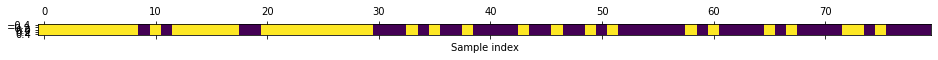

In [10]:
mask = select.get_support()
print(mask)
# 将遮罩可视化——黑色为True，白色为False
plt.matshow(mask.reshape(1, -1))
plt.xlabel("Sample index")
plt.show()

In [11]:
from sklearn.linear_model import LogisticRegression

# 对测试数据进行变换
X_test_selected = select.transform(X_test)

lr = LogisticRegression(max_iter=4000)
lr.fit(X_train, y_train)
print("Score with all features: {:.3f}".format(lr.score(X_test, y_test)))
lr.fit(X_train_selected, y_train)
print("Score with only selected features: {:.3f}".format(
    lr.score(X_test_selected, y_test)))

Score with all features: 0.951
Score with only selected features: 0.933


In [12]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median")

In [13]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


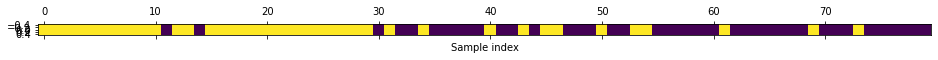

In [14]:
mask = select.get_support()
# 将遮罩可视化——黑色为True，白色为False
plt.matshow(mask.reshape(1, -1))
plt.xlabel("Sample index")
plt.show()

In [15]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression(max_iter=4000).fit(X_train_l1, y_train).score(X_test_l1, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.947
